[Original Post](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html) <br>
[Updated Post](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

General Case: Canonical seq-2-seq <p>
Input and Output sequences have different lengths, and entire input sequence is required in order to start predicting the target. Requires a more advanced setup. How it works:
-  RNN layer (or stack of) acts as an 'encoder'; processes input sequence and returns its own internal state. Note we will discard the outputs of encoder RNN, only recovering the state. This will serve as the 'context', or 'conditioning' of the decoder in the next step.
-  Another RNN layer (or stack of) acts as the 'decoder'; it is trained to predict the next characters of the target sequence, given previous characters of the target sequence. Specifically, it is trained to turn the target sequences into the same sequences but offset by one timestep in the future, a training process called 'teacher forcing' in this context. <br>
Importantly, the decoder uses as an initial state the state vectors from the encoder, which is how the decoder obtains information about what it is supposed to generate. Effectively, the decoder learns to generate targets[t+1] given targets[...t], and thus is conditioned on the input sequence.


In inference mode, we want to decode unknown input sequences, so we go through a slightly different process:
1.  Encode input sequence into state vectors
2.  Start with target sequence of size 1 (start of sequence character)
3.  Feed state vectors and 1-char target sequence to decoder to produce predictions for the next character
4.  Sample next character using these predictions (use simple argmax)
5.  Append the sampled character to target sequence
6.  Repeat until we generate end of sequence character or hit the character limit -  until we generate [STOP]

Note: `Teacher forcing` is a ML method for training RNN models that use the ground truth from a prior step as the input. [Source](https://machinelearningmastery.com/teacher-forcing-for-recurrent-neural-networks/)

Keras Example <p>
Will use a dataset of English-French translation pairs. Will implement character-level seq-2-seq, processing input character-by-character and producing the output in the same manner. <br>
Another option is to have a word-level model (tends to be more commend for Machine Translation); can look at in the end of the post..<p>

Process Summary:
1.  Turn sentences into 3 Numpy arrays: 
    -  `encoder_input_data`: 3D array of shape `(num_pairs, max_english_sentence_length, num_english_characters)`; containing a one-hot vectorization of the English sentences
    -  `decoder_input_data`: 3D array of shape `(num_pairs, max_french_sentence_length, num_french_characters)`; containing one-hot vectorization of the French Sentences
    -  `decoder_target_data`: Same as `decoder_input_data`, but offset by one timestep. `decoder_target_data[:, t, :]` will be the same as `decoder_input_data[:, t+1, :]`
2.  Train a basic LSTM-based Seq2Seq model to predict `decoder_target_data` given `encoder_input_data` and `decoder_input_data`. Or model uses teacher forcing.
3.  Decode some sentences to check that the model is working (i.e. turn samples from `encoder_input_data` into corresponding samples from `decoder_target_data`).
<p>

Because the training and inference process are different, we use different models for both; albeit they all leverage the same inner layers. <br>
Our training model leverages three key features of Keras RNN's:
-  `return_state` constructor argument, configuring a RNN layer to return a list where the first entry is the outputs and the next entries are the RNN states. These are used to recovere the states of the encoder.
-  The `initial_state` call argument, specifying the initial state(s) of a RNN; this is used to pass the encoder states to the decoder as initial states.
-  The `return_sequences` constructor argument, configuring a RNN to return its full sequence of outputs (instead of just the last output, which is the default behaviour). This is used in the decoder.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
## Download the file
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip

['Archive:  fra-eng.zip',
 'replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n',
 'replace fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n']

In [3]:
## config
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

# Path to the data txt file on disk.
data_path = "fra.txt"

In [4]:
## Prepare the data


# initialise arrays to store texts and characters
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()

# open dataset and read lines
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

# only take up to max num samples or the length of the dataset
for line in lines[: min(num_samples, len(lines) - 1)]:

    # split texts; input, target, info..
    input_text, target_text, _ = line.split("\t") 

    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"

    # append to input and target lists of texts
    input_texts.append(input_text)
    target_texts.append(target_text)

    # append characters to input and target text sets
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

# turn sets to list and sort
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])
# print some summary stats
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 15
Max sequence length for outputs: 59


In [5]:
# create indexes of character to index num for input and target
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])
print('Number of input tokens', len(input_token_index))
print('Number of target tokens', len(target_token_index))

# create input and target arrays
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
# decoder target is the same dimensions as decoder input data
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
print("Encoder Input data Shape", encoder_input_data.shape)
print('Decoder Input/Target data Shape', decoder_target_data.shape)

Number of input tokens 71
Number of target tokens 92
Encoder Input data Shape (10000, 15, 71)
Decoder Input/Target data Shape (10000, 59, 92)


In [6]:
# go through each input text and target text to fill in training inputs
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        
    # for input token; set value to 1 in encoder input wherever there is a character.
    # also for the space after the input text location; a blank space token
    # one-hot representation of the characters that are present for that text
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0 # becomes a very sparse matrix..
    # set everything else as having empty space; as no value present for those
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

    # do the same for target data; set 1 wherever there is a character for each text
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        # as encoder wants to predict next timestep; so decoder is just one step ahead..
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            # >> So there is information of one-ahead timestep (what we want to predict)
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0 # shows the character one timestep earlier; no beginning char

    # everything else has empty space; no value present for such tokens..
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0 # feeding in t+1; mask all after
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0 # 


In [7]:
## build the model

# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# build dense layer with number of output tokens and predict based on decoder outputs
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 71)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 92)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        335872      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

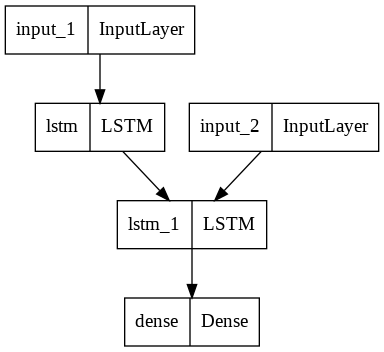

In [9]:
tf.keras.utils.plot_model(model)

In [ ]:
# train our model
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")

In [11]:
## Define sampling models

# Restore the model and construct the encoder and decoder.
model = keras.models.load_model("s2s")

encoder_model = keras.Model(encoder_inputs, encoder_states) #re-build

# construct decoder
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c] # define inputs to our decoder
# run inputs through lstm
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec] # get decoder states
decoder_outputs = decoder_dense(decoder_outputs)
# create decoder model; input of 
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, # create [inputs, h, c]
    [decoder_outputs] + decoder_states # decoder outputs; dense layer decoder outputs to get representation
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens)) # all the possible tokens; just a one hot encoded vector of one word...
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:

        # predict output tokens based on current target sequence, and current states value
        # states value from encoder model
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c] #update h, c
    return decoded_sentence

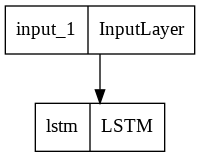

In [14]:
tf.keras.utils.plot_model(encoder_model)

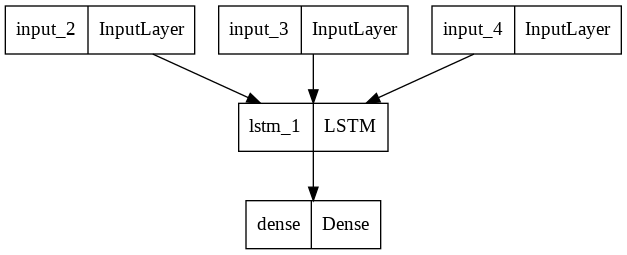

In [13]:
# input sequence; target sequence of 1 before, then h and c layers
tf.keras.utils.plot_model(decoder_model)

In [ ]:
# can now generate decoded sequences
for seq_index in range(50):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)
    break

-
Input sentence: Go.
Decoded sentence: Je s e                                                      
